In [81]:
import requests
import json
import datetime
from datetime import datetime as dt
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

key = "pk_9c2106af1aae418caef36540478d4b1a"
ticker = "nflx"


In [82]:
prev_yr = "https://cloud.iexapis.com/stable/stock/"+ticker+"/chart/1y?token="+key
prev_day = "https://cloud.iexapis.com/stable/stock/"+ticker+"/chart/1d?token="+key
present_day = "https://cloud.iexapis.com/stable/stock/"+ticker+"/intraday-prices/batch?token="+key

In [83]:
prevyr_data = requests.get(prev_yr)
prevday_data = requests.get(prev_day)
presday_data = requests.get(present_day)


prevyr = json.loads(prevyr_data.text)
prevday = json.loads(prevday_data.text)
presentday = json.loads(presday_data.text)



In [84]:
#Converting dates to timestamps

for i in prevyr:
    i['minute'] = i.get('minute','09:30')

for i in prevyr:
        string = i['date']+'T'+i['minute']+':00+00:00'
        element= dt.strptime(string,"%Y-%m-%dT%H:%M:%S+00:00")
        tuple = element.timetuple() 
        timestamp = time.mktime(tuple)
        i['timestamps']= i.get('timestamps',timestamp)

for i in prevday:
        string = i['date']+'T'+i['minute']+':00+00:00'
        element= dt.strptime(string,"%Y-%m-%dT%H:%M:%S+00:00")
        tuple = element.timetuple() 
        timestamp = time.mktime(tuple)
        i['timestamps']= i.get('timestamps',timestamp)

for i in presentday:
        string = i['date']+'T'+i['minute']+':00+00:00'
        element= dt.strptime(string,"%Y-%m-%dT%H:%M:%S+00:00")
        tuple = element.timetuple() 
        timestamp = time.mktime(tuple)
        i['timestamps']= i.get('timestamps',timestamp)

In [161]:
# Making DataFrames
pd.set_option("display.precision", 6)

df_prevyr= pd.DataFrame(prevyr)
df_prevday= pd.DataFrame(prevday)
df_presday= pd.DataFrame(presentday)

dataset = pd.concat([df_prevyr, df_prevday, df_presday])
dataset = dataset.drop(['close','high','low','volume','uOpen','uHigh','uLow','uVolume','change','label','changeOverTime','uClose','minute','date','changePercent','average','notional','numberOfTrades'],axis=1)
dataset.head(10)

,open,timestamps
0,265.97,1.570700e+09
1,284.80,1.570786e+09
2,283.93,1.571045e+09
3,283.82,1.571132e+09
4,283.12,1.571218e+09
5,304.49,1.571305e+09
6,289.36,1.571391e+09
7,272.89,1.571650e+09
8,271.16,1.571737e+09
9,268.06,1.571823e+09


In [162]:
dataset[dataset==np.inf]=np.nan
dataset.fillna(dataset.mean(), inplace=True)
dataset.timestamps[0:5]

0    1.570700e+09
1    1.570786e+09
2    1.571045e+09
3    1.571132e+09
4    1.571218e+09
Name: timestamps, dtype: float64

In [163]:
array = dataset.values
X = array[:,1]
X = X.reshape(-1,1)
y = array[:,0]

In [173]:
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.3, random_state=3)

In [174]:
models = []
models.append((' LR ', LinearRegression()))
models.append((' LASSO ', Lasso()))
models.append((' EN ', ElasticNet()))
models.append((' KNN ', KNeighborsRegressor()))
models.append((' CART ', DecisionTreeRegressor()))
models.append((' SVR ', SVR()))

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=3, random_state=1, shuffle=True)
    cv_score = cross_val_score(
        model, X_train, y_train, cv=kfold, scoring='r2')
    results.append(cv_score)
    names.append(name)
    scores = "%s: %f (%f)" % (name, cv_score.mean(), cv_score.std())
    print(scores)

 LR : 0.975131 (0.004411)
 LASSO : 0.975131 (0.004411)
 EN : 0.975131 (0.004411)
 KNN : 0.989235 (0.001180)
 CART : 0.989107 (0.001135)
 SVR : 0.696252 (0.035962)


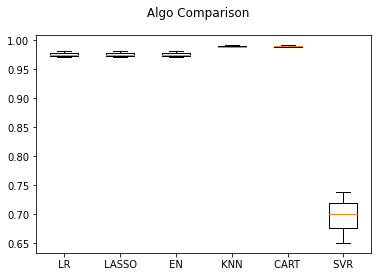

In [175]:
fig = plt.figure()
fig.suptitle(' Algo Comparison ')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [176]:
#KNN and CART gave 98.889% accuracy in prdeicting the model

model = DecisionTreeRegressor(max_depth=20)
model.fit(X_train, y_train)

predictions = model.predict(X_val)
print(r2_score(y_val, predictions))

0.9836722673061128


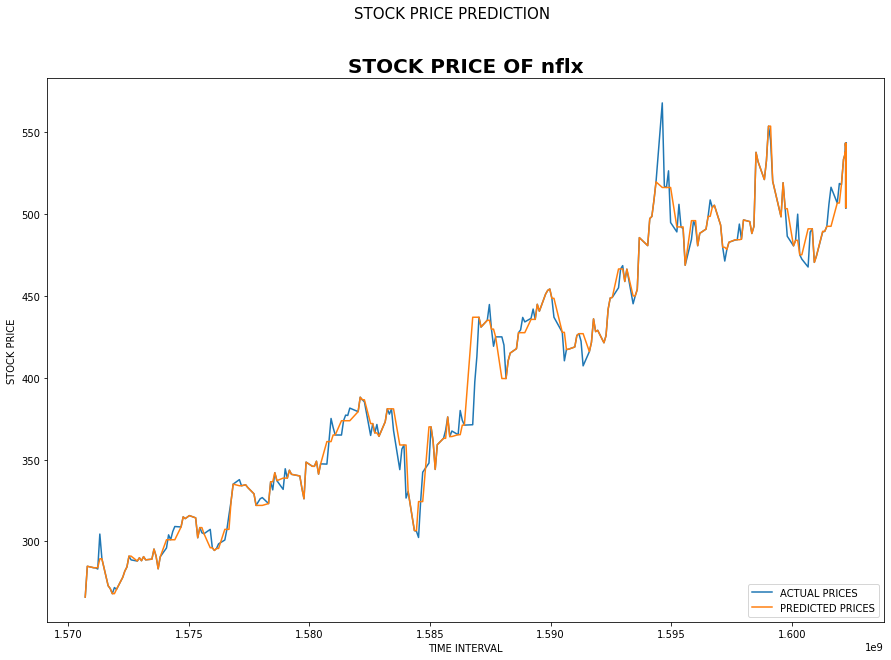

In [177]:
figure = plt.figure(figsize=(15,10))
plt.plot(X, y, label="ACTUAL PRICES")
plt.plot(X, model.predict(X.reshape(-1,1)), label="PREDICTED PRICES")
plt.legend(loc='lower right')
plt.title("STOCK PRICE OF "+ ticker, fontsize=20, fontweight='bold')
plt.suptitle("STOCK PRICE PREDICTION", fontsize=15)
plt.xlabel("TIME INTERVAL")
plt.ylabel("STOCK PRICE")
plt.show()